# Force Plate Static Analytics

Falk Mielke, Universiteit Antwerpen

Nov 26, 2018



I'm interested to model a kistler force plate. I plan to attach sockets (padding) to it to reduce contact surface, yet this requires a correction of the contact point or centre of pressure (COP).

<img src="images/forceplate.png">

Unfortunately, documentation for the device is sparse, despite its substantial price.

There's one older, non-manufacturer attempt to capture the basic formulas of the force plate physics:
https://isbweb.org/software/movanal/vaughan/kistler.pdf (Kit Vaughan, Feb. 5, 1999).


<img src="images/vaughan_scheme.png">

There is another excellent documentation for software by Young-Hoo Kwon (1998) here:

http://www.kwon3d.com/theory/grf/cop.html

http://www.kwon3d.com/theory/grf/pad.html



The dimensions $a$, $b$ and $az_0$ must be specified in the software, and need not necessarily match the actual configuration. I found no manufacturer documentation of an exact value for $az_0$, but assume the piezos are just below an adapter plate that is screwed to the top of the Kistler force plate, hence $1\ cm$ below the top surface.  

On preliminary inspection, the formulas provided by Vaughan matched the Kistler Bioware software export, as long as there was no significant padding. When padding is higher, the formulas do not match the software export with regard to contact point ($CoP_x$, $CoP_y$) and free torque $T_z$.

## Setup

For testing, I put one leg of a tripod of approximately $\sum\limits_{legs} = 257\ N$ on the force plate. I intend to measure whether the software gives expected results. 

The tripod is regular photo equipment and balanced so that, upon measurement, all legs carry approximately the same share of the weight of the device, and tripod leg contacts are at the same height. Then, static impact forces (average of $>3\ s$ steady state) of each leg in turn are measured.

The measurements include:
- different padding installations (no padding: $az_0 = -1\ cm$; padding: $az_0 = -10\ cm$)
- three different padding settings in the software to check whether the vertical piezo position was correctly assumed
- different contact points (in cm: $(0, -6);\ (0, 0);\ (0, +6)$)
- three legs in turn

below an overview of the test setup.

<img src="images/setup.jpg" width="800">

## Aim of this Notebook


Below, I use the documentation by Kwon and other sources to calculate the expected impact **parameters** (forces, moments, contact point) from the raw force **components** (i.e. piezo signals). I define this as the forward calculation.



I am also interested in a backwards calculation, i.e. inferring hypothetical piezo force components from a given set of parameters. This would allow to compare theoretical scenarios to the actual outcomes.

# Forward Calculation: Parameters from Components


Here is a collection of `python` libraries used below, as well as some helper functions.

Most notably, we will use `sympy` (https://docs.sympy.org/latest/) which has an excellent support for classical mechanics.

In [1]:
#######################################################################
### Libraries                                                       ###
#######################################################################
# data management
import numpy as NP
import pandas as PD
PD.set_option('precision', 5)

# symbolic maths
import sympy as SYM
import sympy.physics.mechanics as MECH
from sympy.matrices import rot_axis3 as ROT3

# plots and graphics
import matplotlib as MP
import matplotlib.pyplot as MPP
from IPython.core.display import SVG

%matplotlib inline

# formula printing
SYM.init_printing(use_latex=False)

# vector (de)composition helpers
VectorComponents = lambda vec, rf: [vec.dot(rf.x), vec.dot(rf.y), vec.dot(rf.z)]
MakeVector = lambda components, coords, n = 3: sum(NP.multiply(components[:n], coords[:n]))
ChangeAFrame = lambda vec, rf_old, rf_new: MakeVector(VectorComponents(vec, rf_old), [rf_new.x, rf_new.y, rf_new.z])

SmallAngleApprox = lambda ang: [(SYM.sin(ang), ang), (SYM.cos(ang), 1), (SYM.tan(ang), ang)]

def PrintSolution(solution_dict):
    # print and substitute in known values
    for param, eqn in solution_dict.items():
        print ('\n', '_'*20)
        print (param)
        print ('_'*20)
        SYM.pprint(eqn.subs(fp_dimensions))

We now define our force plate as a reference frame in the world, with the following notation. This notation deviates from Kistler terminology and from the sources listed above, but is used here consistently.
This involves the following points:
- the center $C$ of the force plate, which is the origin of the reference frame
- the impact point $P$, i.e. contact / centre of pressure
- coplanar piezo positions $Q$ (analogous to table legs)

<img src="images/notation.png" width="800">

First, create a force plate in the world.

In [2]:
### reference frame of the force plate
world = MECH.ReferenceFrame('N')
origin = MECH.Point('O')
origin.set_vel(world, 0)

phi = SYM.symbols('phi_{x:z}') # force plate rotation in the world
forceplate = world.orientnew('fp', 'Body', phi[::-1], 'ZYX')

# center point = force plate center of mass
forceplate_offset = SYM.symbols('c_{x:z}')
center = origin.locatenew('C', MakeVector(forceplate_offset, [world.x, world.y, world.z]))


# force plate coordinate system
x = forceplate.x
y = forceplate.y
z = forceplate.z
coordinates = [x, y, z]
coord_strings = ['x', 'y', 'z']

# notation: 
#    i ... leg index
#    j ... coordinate index

# impact point
pj = SYM.symbols('p_{x:z}')
impact = center.locatenew('P', MakeVector(pj, coordinates))

# impact position vector
rc = impact.pos_from(center)

rc

p_{x} fp_x + p_{y} fp_y + p_{z} fp_z

The force plate has "legs", which are the piezo measurement points in which the reaction forces are measured.

In [3]:
# leg points, relative to force plate center
n_legs = 4
leg_ids = range(n_legs)
leg_positions = NP.array([(k,l) for k, l in [[+1,+1], [-1,+1], [-1,-1], [+1,-1]] ])

# leg vectors
qj = SYM.symbols('q_{x:y}') # plate dimensions
rq = [leg_positions[i,0]*qj[0]*x + leg_positions[i,1]*qj[1]*y + 0*z for i in leg_ids] 


# leg points
legs = [center.locatenew('Q_{%i}' % (i), rq[i]) for i in leg_ids]

# vector from leg to impact
sq = [leg.pos_from(impact) for leg in legs] # leg - impact

for i in leg_ids:
    SYM.pprint(rq[i])
    SYM.pprint(sq[i])


q_{x} fp_x + q_{y} fp_y
(-p_{x} + q_{x}) fp_x + (-p_{y} + q_{y}) fp_y + -p_{z} fp_z
-q_{x} fp_x + q_{y} fp_y
(-p_{x} - q_{x}) fp_x + (-p_{y} + q_{y}) fp_y + -p_{z} fp_z
-q_{x} fp_x + -q_{y} fp_y
(-p_{x} - q_{x}) fp_x + (-p_{y} - q_{y}) fp_y + -p_{z} fp_z
q_{x} fp_x + -q_{y} fp_y
(-p_{x} + q_{x}) fp_x + (-p_{y} - q_{y}) fp_y + -p_{z} fp_z


Finally, some dimensions of the force plate will be substituted.

In [4]:
fp_dimensions = [(qj[0], 0.035), (qj[1], 0.075)]
# padding (pj[2]) has to come from the data


## Balance of Forces

First, we'll gather the reaction forces $f_{ij}$ ($i$: leg index, $j$: coordinate) on the legs (piezos).

In [5]:
fij = NP.array(SYM.symbols('f_{:4x:z}')).reshape(n_legs, -1)

Fi = [MakeVector(fij[i,:], coordinates) for i in leg_ids]

print(Fi)

[f_{0x}*fp.x + f_{0y}*fp.y + f_{0z}*fp.z, f_{1x}*fp.x + f_{1y}*fp.y + f_{1z}*fp.z, f_{2x}*fp.x + f_{2y}*fp.y + f_{2z}*fp.z, f_{3x}*fp.x + f_{3y}*fp.y + f_{3z}*fp.z]


Then sum up the forces and equal them to the impact force

In [6]:
Fj = SYM.symbols('F_{x:z}')

impact_components = Fj
reactn_components = VectorComponents(sum(Fi), forceplate)


force_balances = [SYM.Eq(impact_components[coord], reactn_components[coord]) for coord, _ in enumerate(coordinates) ]
#SYM.pprint(force_balances)

force_subs = [(imp, rcn) for imp, rcn in zip(impact_components, reactn_components)]
force_subs

[(F_{x}, f_{0x} + f_{1x} + f_{2x} + f_{3x}), (F_{y}, f_{0y} + f_{1y} + f_{2y} 
+ f_{3y}), (F_{z}, f_{0z} + f_{1z} + f_{2z} + f_{3z})]

## Balance of Moments

- Each load has a net moment at the center of mass.

- Each reaction force applies a moment back to the force plate, towards the center point.

- $T_z$ is torque around impact ("frictional torque"), $M_2$ is torque around center, but they add in magnitude.

impact moments:

In [7]:
# free moment
Tz = SYM.symbols('T_{z}')


# moments of the impact force on the whole object
impact_moments = rc.cross(MakeVector(Fj, coordinates))
impact_moments += Tz*z
impact_moments

(-F_{y}⋅p_{z} + F_{z}⋅p_{y}) fp_x + (F_{x}⋅p_{z} - F_{z}⋅p_{x}) fp_y + (-F_{x}
⋅p_{y} + F_{y}⋅p_{x} + T_{z}) fp_z

reaction moments:

In [8]:
# moments of the reaction forces on the legs on the whole object (i.e. center)
reactn_moments = [rq[i].cross(MakeVector(fij[i, :], coordinates )) \
                  for i in leg_ids]
# print(reactn_moments)

reactn_moments = [vc.factor(pj+qj) for vc in VectorComponents(sum(reactn_moments), forceplate)]
reactn_moments

[q_{y}⋅(f_{0z} + f_{1z} - f_{2z} - f_{3z}), q_{x}⋅(-f_{0z} + f_{1z} + f_{2z} -
 f_{3z}), q_{x}⋅(f_{0y} - f_{1y} - f_{2y} + f_{3y}) + q_{y}⋅(-f_{0x} - f_{1x} 
+ f_{2x} + f_{3x})]

All moments add to zero, in each coordinate direction separately.

In [9]:
moment_equations = [SYM.Eq(imp, rcn).subs(force_subs).simplify() \
                    for imp, rcn in zip(VectorComponents(impact_moments, forceplate), reactn_moments)]
moment_equations

[q_{y}⋅(f_{0z} + f_{1z} - f_{2z} - f_{3z}) = p_{y}⋅(f_{0z} + f_{1z} + f_{2z} +
 f_{3z}) - p_{z}⋅(f_{0y} + f_{1y} + f_{2y} + f_{3y}), q_{x}⋅(-f_{0z} + f_{1z} 
+ f_{2z} - f_{3z}) = -p_{x}⋅(f_{0z} + f_{1z} + f_{2z} + f_{3z}) + p_{z}⋅(f_{0x
} + f_{1x} + f_{2x} + f_{3x}), T_{z} + p_{x}⋅(f_{0y} + f_{1y} + f_{2y} + f_{3y
}) - p_{y}⋅(f_{0x} + f_{1x} + f_{2x} + f_{3x}) = q_{x}⋅(f_{0y} - f_{1y} - f_{2
y} + f_{3y}) - q_{y}⋅(f_{0x} + f_{1x} - f_{2x} - f_{3x})]

## Solution

We now solve for the different parameters consecutively.

In kistler force plates, piezo measurements are grouped for the $x$- and $y$-direction. This will be substituted below.

In [10]:

fx01, fx23, fy03, fy12 = SYM.symbols('fx_{01}, fx_{23}, fy_{03}, fy_{12}')
fz = SYM.symbols('fz_{:4}')

force_components = [fx01, fx23, fy03, fy12] + [f for f in fz]

group_subs = [ (fij[0,0]+fij[1,0], fx01) \
             , (fij[2,0]+fij[3,0], fx23) \
             , (fij[0,1]+fij[3,1], fy03) \
             , (fij[1,1]+fij[2,1], fy12) \
             ] + [ \
             (fij[i,2], fz[i]) for i in leg_ids \
             ]

group_subs

[(f_{0x} + f_{1x}, fx_{01}), (f_{2x} + f_{3x}, fx_{23}), (f_{0y} + f_{3y}, fy_
{03}), (f_{1y} + f_{2y}, fy_{12}), (f_{0z}, fz_{0}), (f_{1z}, fz_{1}), (f_{2z}
, fz_{2}), (f_{3z}, fz_{3})]

In [11]:
moment_equations = [mmnt.factor(qj+pj).subs(group_subs) for mmnt in moment_equations]
moment_equations

[q_{y}⋅(fz_{0} + fz_{1} - fz_{2} - fz_{3}) = p_{y}⋅(fz_{0} + fz_{1} + fz_{2} +
 fz_{3}) + p_{z}⋅(-fy_{03} - fy_{12}), q_{x}⋅(-fz_{0} + fz_{1} + fz_{2} - fz_{
3}) = -p_{x}⋅(fz_{0} + fz_{1} + fz_{2} + fz_{3}) - p_{z}⋅(-fx_{01} - fx_{23}),
 T_{z} + p_{x}⋅(fy_{03} + fy_{12}) + p_{y}⋅(-fx_{01} - fx_{23}) = q_{x}⋅(fy_{0
3} - fy_{12}) + q_{y}⋅(-fx_{01} + fx_{23})]

First, the contact point coordinates can be extracted from the moment equations.

In [12]:
solvents = [pj[0], pj[1]]

p_solutions = [ \
             {solvents[s]: sln.factor(pj+qj) \
                  for s, sln in enumerate(solution)} \
             for solution in SYM.nonlinsolve(moment_equations, solvents) \
            ][0]
p_solutions

⎧       p_{z}⋅(fx_{01} + fx_{23}) + q_{x}⋅(fz_{0} - fz_{1} - fz_{2} + fz_{3}) 
⎨p_{x}: ─────────────────────────────────────────────────────────────────────,
⎩                         fz_{0} + fz_{1} + fz_{2} + fz_{3}                   

        p_{z}⋅(fy_{03} + fy_{12}) + q_{y}⋅(fz_{0} + fz_{1} - fz_{2} - fz_{3})⎫
 p_{y}: ─────────────────────────────────────────────────────────────────────⎬
                          fz_{0} + fz_{1} + fz_{2} + fz_{3}                  ⎭

Free torque follows.

In [13]:
tz_equation = moment_equations[2].subs([(pnt, sol) for pnt, sol in p_solutions.items()]).factor(qj+pj)
tz_solution = [sol for sol in SYM.solveset(tz_equation, Tz)][0]
print (tz_solution)

-2*(fx_{01}*fz_{2}*q_{y} + fx_{01}*fz_{3}*q_{y} - fx_{23}*fz_{0}*q_{y} - fx_{23}*fz_{1}*q_{y} - fy_{03}*fz_{1}*q_{x} - fy_{03}*fz_{2}*q_{x} + fy_{12}*fz_{0}*q_{x} + fy_{12}*fz_{3}*q_{x})/(fz_{0} + fz_{1} + fz_{2} + fz_{3})


This gives all parameters related to the impact point.

In [14]:
cop_solutions = {Tz: tz_solution.simplify(), **p_solutions}
cop_solutions

⎧       2⋅(-fx_{01}⋅fz_{2}⋅q_{y} - fx_{01}⋅fz_{3}⋅q_{y} + fx_{23}⋅fz_{0}⋅q_{y}
⎨T_{z}: ──────────────────────────────────────────────────────────────────────
⎩                                                                             

 + fx_{23}⋅fz_{1}⋅q_{y} + fy_{03}⋅fz_{1}⋅q_{x} + fy_{03}⋅fz_{2}⋅q_{x} - fy_{12
──────────────────────────────────────────────────────────────────────────────
      fz_{0} + fz_{1} + fz_{2} + fz_{3}                                       

}⋅fz_{0}⋅q_{x} - fy_{12}⋅fz_{3}⋅q_{x})         p_{z}⋅(fx_{01} + fx_{23}) + q_{
──────────────────────────────────────, p_{x}: ───────────────────────────────
                                                                 fz_{0} + fz_{

x}⋅(fz_{0} - fz_{1} - fz_{2} + fz_{3})         p_{z}⋅(fy_{03} + fy_{12}) + q_{
──────────────────────────────────────, p_{y}: ───────────────────────────────
1} + fz_{2} + fz_{3}                                             fz_{0} + fz_{

y}⋅(fz_{0} + fz_{1} - fz_{2} - fz_{3})⎫
────────

## Resubstitution

Force parameters are a trivial sum of the piezo measurements.

In [15]:
force_solutions = {imp: rcn.subs(group_subs) for imp, rcn in force_subs}
force_solutions

{F_{x}: fx_{01} + fx_{23}, F_{y}: fy_{03} + fy_{12}, F_{z}: fz_{0} + fz_{1} + 
fz_{2} + fz_{3}}

Moment parameters can be retrieved from these forces.

In [16]:
Mj = SYM.symbols('M_{x:z}')
moment_solutions = VectorComponents(impact_moments.subs([(param, sol) for param, sol in cop_solutions.items()]), forceplate)

moment_solutions = {Mj[j]: moment_solutions[j].subs( \
                                                    [(force, sol) for force, sol in force_solutions.items()] \
                                                   ).simplify() \
                    for j, _ in enumerate(coordinates)}

moment_solutions


{M_{x}: q_{y}⋅(fz_{0} + fz_{1} - fz_{2} - fz_{3}), M_{y}: q_{x}⋅(-fz_{0} + fz_
{1} + fz_{2} - fz_{3}), M_{z}: -fx_{01}⋅q_{y} + fx_{23}⋅q_{y} + fy_{03}⋅q_{x} 
- fy_{12}⋅q_{x}}

Now everything is in place and the solution can be gathered.

## Compined Solution

In [17]:
all_solutions = {**force_solutions, **moment_solutions, **cop_solutions}

PrintSolution(all_solutions)

parameters = list(all_solutions.keys())
parameters


 ____________________
F_{x}
____________________
fx_{01} + fx_{23}

 ____________________
F_{y}
____________________
fy_{03} + fy_{12}

 ____________________
F_{z}
____________________
fz_{0} + fz_{1} + fz_{2} + fz_{3}

 ____________________
M_{x}
____________________
0.075⋅fz_{0} + 0.075⋅fz_{1} - 0.075⋅fz_{2} - 0.075⋅fz_{3}

 ____________________
M_{y}
____________________
-0.035⋅fz_{0} + 0.035⋅fz_{1} + 0.035⋅fz_{2} - 0.035⋅fz_{3}

 ____________________
M_{z}
____________________
-0.075⋅fx_{01} + 0.075⋅fx_{23} + 0.035⋅fy_{03} - 0.035⋅fy_{12}

 ____________________
T_{z}
____________________
2⋅(-0.075⋅fx_{01}⋅fz_{2} - 0.075⋅fx_{01}⋅fz_{3} + 0.075⋅fx_{23}⋅fz_{0} + 0.075
──────────────────────────────────────────────────────────────────────────────
                                                                            fz

⋅fx_{23}⋅fz_{1} + 0.035⋅fy_{03}⋅fz_{1} + 0.035⋅fy_{03}⋅fz_{2} - 0.035⋅fy_{12}⋅
──────────────────────────────────────────────────────────────────────────────
_{0}

[F_{x}, F_{y}, F_{z}, M_{x}, M_{y}, M_{z}, T_{z}, p_{x}, p_{y}]

Sympy offers a convenient way to create functions in which we plug the piezo components and retrieve the parameters.

In [18]:
# generate conversion functions
ComponentsToParameters = { str(param): \
                              SYM.lambdify(force_components + [pj[2]], eqn.subs(fp_dimensions), "numpy") \
                          for param, eqn in all_solutions.items()\
                         }

## Plug Values

### Measured Test Data

Here is what was measured with the tripod.

In [19]:
parameter_labels = ['F_{x}', 'F_{y}', 'F_{z}', 'M_{x}', 'M_{y}', 'M_{z}', 'T_{z}', 'p_{x}', 'p_{y}']
rawmeasure_labels = ['Fx12', 'Fx34', 'Fy14', 'Fy23', 'Fz1', 'Fz2', 'Fz3', 'Fz4','padding_setting']

data = PD.read_csv('measurements.csv', sep = ';')
#print (data.columns)
data = data.loc[ data['test'].values == 'cent', : ].reset_index()
data['padding_setting'] = -1*NP.abs(data['target_pz'] + 0.01 - (data['padding_offset']*1e-3))

# correct moments for padding: data file contains Mj', but we calculate with Mj
data.loc[:, 'M_{x}'] -= data.loc[:, 'F_{y}'].values * data.loc[:, 'padding_setting'].values
data.loc[:, 'M_{y}'] += data.loc[:, 'F_{x}'].values * data.loc[:, 'padding_setting'].values


data_grp = data.groupby(['padding_category', 'position_category', 'padding_setting'] \
                    ).agg(NP.mean \
                    ).reset_index().loc[:, ['padding_category', 'position_category', 'padding_offset']\
                                           + rawmeasure_labels  \
                                           + parameter_labels  \
                                           + ['target_px', 'target_py', 'target_pz' \
                                             ] \
                    ]

data_grp.head()

padding_category  position_category  padding_offset     Fx12     Fx34  \
0                A                  1              35 -0.30759  3.01027   
1                A                  1              10 -0.44969  2.22376   
2                A                  1               0  0.70157  1.70449   
3                A                  2              35 -1.23516  0.54466   
4                A                  2              10 -0.01072  2.53403   

      Fy14      Fy23      Fz1       Fz2       Fz3    ...         F_{z}  \
0  6.65758   9.10006 -2.99647  11.67912  29.50285    ...      85.39565   
1  8.90320  12.16281 -3.60803  13.58423  26.42433    ...      84.24424   
2  9.97339   9.58649 -3.69970  14.88832  26.61988    ...      84.34733   
3  8.19918  11.54813 -0.47772  44.08280   1.30358    ...      83.57082   
4  8.04375  13.30010  0.62404  43.68112   0.73338    ...      83.87794   

     M_{x}    M_{y}    M_{z}    T_{z}    p_{x}    p_{y}  target_px  target_py  \
0 -5.10228 -0.10611  0.16335 -0.02791  0.00590 -0.01548        0.0      -0.06   
1 -4.82189 -0.14795  0.08642 -0.04648 -0.00187 -0.01824        0.0      -0.06   
2 -4.64776 -0.04658  0.08876 -0.05009 -0.00358  0.00950        0.0      -0.06   
3  0.27295  0.25207  0.01627  0.06960  0.00803  0.00518        0.0       0.00   
4  0.35493  0.17329  0.00688  0.05905  0.00422  0.01749        0.0       0.00   

   target_pz  
0      -0.01  
1      -0.01  
2      -0.01  
3      -0.01  
4      -0.01  

[5 rows x 24 columns]

### Calculated data

We can compare this to the calculation.

In [20]:
datavectors = [data.loc[:,col].values for col in rawmeasure_labels]
avg_vectors = [data_grp.loc[:,col].values for col in rawmeasure_labels]

calculated_values = PD.DataFrame.from_dict({param: eqn(*datavectors) for param, eqn in ComponentsToParameters.items()})
calculated_averages = PD.DataFrame.from_dict({param: eqn(*avg_vectors) for param, eqn in ComponentsToParameters.items()})
test_df = data_grp.loc[:, ['padding_setting', 'target_py', 'target_pz']].join(calculated_averages)

# + pad * fy / fz
#test_df['corrected_py'] = test_df['p_{y}'] + test_df['target_pz'].values * (test_df['F_{y}'].values / test_df['F_{z}'].values )
test_df.head()

padding_setting  target_py  target_pz    F_{x}     F_{y}     F_{z}  \
0           -0.035      -0.06      -0.01  2.70268  15.75764  85.39565   
1           -0.010      -0.06      -0.01  1.77408  21.06601  84.24424   
2           -0.000      -0.06      -0.01  2.40606  19.55988  84.34733   
3           -0.035       0.00      -0.01 -0.69050  19.74731  83.57082   
4           -0.010       0.00      -0.01  2.52331  21.34384  83.87794   

     M_{x}    M_{y}    M_{z}    T_{z}    p_{x}    p_{y}  
0 -5.10228 -0.10611  0.16335 -0.01771  0.00013 -0.06621  
1 -4.82189 -0.14795  0.08642 -0.05212  0.00155 -0.05974  
2 -4.64776 -0.04658  0.08876 -0.05462  0.00055 -0.05510  
3  0.27295  0.25207  0.01627  0.07358 -0.00273 -0.00500  
4  0.35493  0.17329  0.00688  0.06166 -0.00237  0.00169

And see the difference:

In [21]:
diff_values = PD.DataFrame.from_dict( { \
                                      param: NP.round(ComponentsToParameters[param](*avg_vectors)-data_grp.loc[:,param].values,5) \
                                      for param in parameter_labels \
                                      })
diff_values

F_{x}  F_{y}  F_{z}  M_{x}  M_{y}  M_{z}    T_{z}    p_{x}    p_{y}
0    -0.0   -0.0   -0.0    0.0   -0.0   -0.0  0.01020 -0.00577 -0.05073
1    -0.0    0.0   -0.0    0.0   -0.0    0.0 -0.00564  0.00342 -0.04150
2    -0.0   -0.0    0.0   -0.0    0.0    0.0 -0.00453  0.00413 -0.06460
3     0.0    0.0    0.0    0.0    0.0    0.0  0.00398 -0.01076 -0.01018
4     0.0    0.0    0.0    0.0   -0.0   -0.0  0.00261 -0.00659 -0.01580
5     0.0   -0.0    0.0    0.0    0.0   -0.0  0.00394 -0.03468 -0.07613
6     0.0   -0.0   -0.0   -0.0   -0.0    0.0  0.00535 -0.01387  0.04720
7     0.0   -0.0   -0.0   -0.0   -0.0   -0.0  0.00054 -0.00620  0.04258
8     0.0   -0.0    0.0   -0.0   -0.0    0.0  0.00360 -0.01055  0.01623
9    -0.0   -0.0    0.0    0.0    0.0    0.0  0.00369 -0.04198 -0.05304
10   -0.0   -0.0    0.0    0.0   -0.0    0.0  0.00066 -0.00611 -0.04308
11   -0.0   -0.0   -0.0    0.0    0.0    0.0 -0.00101 -0.00215 -0.05410
12    0.0    0.0    0.0   -0.0   -0.0   -0.0 -0.00014 -0.03611 -0.02846
13   -0.0    0.0    0.0    0.0    0.0   -0.0  0.00040 -0.05262 -0.03578
14   -0.0   -0.0   -0.0    0.0   -0.0   -0.0  0.00219 -0.00052 -0.04427
15   -0.0    0.0    0.0   -0.0   -0.0   -0.0 -0.00171 -0.04717  0.05299
16    0.0    0.0    0.0   -0.0   -0.0   -0.0  0.00123 -0.05186  0.03820
17   -0.0    0.0    0.0   -0.0   -0.0   -0.0 -0.00170 -0.01792  0.03193

Force and moment parameters from the Kistler Bioware software export are accurately reflected by our analytic calculation.

However, **contact point and free torque do not match.**

## Difference Plot

This can be visualized in a plot of the force plates, top view.

In [22]:

the_font = {  \
        'family': 'sans-serif'
        , 'sans-serif': 'DejaVu Sans'
        , 'size': 10#*1.27 \
    }

MP.rcParams['text.usetex'] = True
MPP.rc('font',**the_font)
# Tell Matplotlib how to ask TeX for this font.
# MP.texmanager.TexManager.font_info['iwona'] = ('iwona', r'\usepackage[light,math]{iwona}')

MP.rcParams['text.latex.preamble'] = [\
              r'\usepackage{upgreek}'
            , r'\usepackage{cmbright}'
            , r'\usepackage{sansmath}'
            ]

MP.rcParams['pdf.fonttype'] = 42 # will make output TrueType (whatever that means)




In [23]:
inspection_data = data.loc[:, ['padding_setting', 'target_px', 'target_py', 'target_pz', 'p_{x}', 'p_{y}']\
                          ].join(calculated_values, how = 'left', lsuffix = '_auto', rsuffix = '_calc')

# padding_settings = NP.unique(data['padding_setting'].values)[::-1]
actual_padding = NP.unique(inspection_data['target_pz'].values)
y_positions = NP.unique(inspection_data['target_py'].values)

print (actual_padding, y_positions)
# inspection_data

[-0.1  -0.01] [-0.06  0.    0.06]


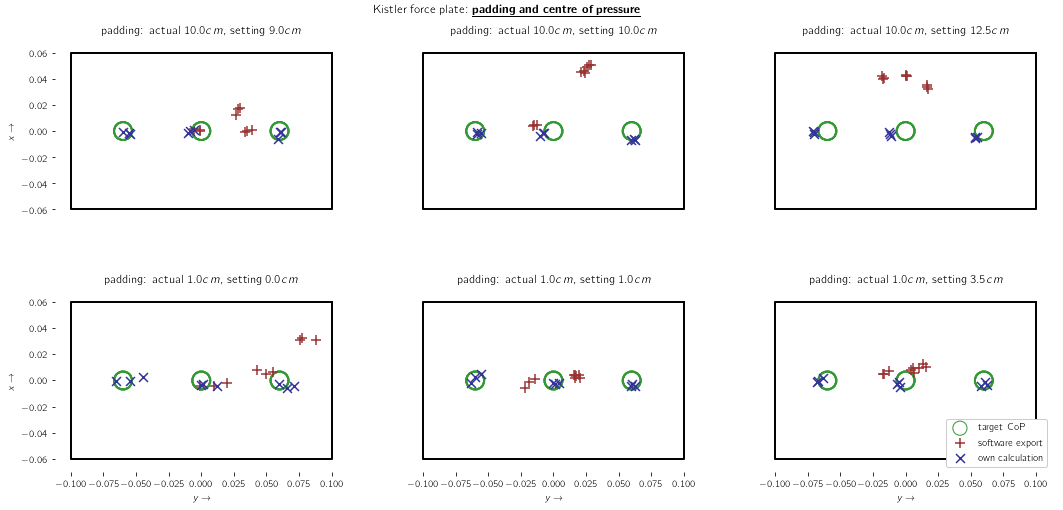

In [24]:
cm = 1./2.54
figwidth  = 2*20 * cm
figheight = 2*10 * cm

# define figure
# columnwidth = 455.24411 # from latex \showthe\columnwidth
fig = MPP.figure( figsize = (figwidth, figheight) \
                , facecolor = None \
                )
# MPP.ion() # "interactive mode". Might e useful here, but i don't know. Try to turn it off later.

# define axis spacing
fig.subplots_adjust(  top    = 0.98 \
                    , right  = 0.98 \
                    , bottom = 0.10 \
                    , left   = 0.10 \
                    , wspace = 0.20 # column spacing \
                    , hspace = 0.00 # row spacing \
                    )

# define subplots
gs = MP.gridspec.GridSpec( \
                              2 # rows
                            , 3 # cols
                            , height_ratios = [1, 1] \
                            , width_ratios = [1, 1, 1] \
                            )


### plot!
leg_pos = NP.concatenate([leg_positions[:,:], [leg_positions[0,:]]], axis = 0)
for row_id, padding in enumerate(actual_padding):
    sub_data = inspection_data.loc[inspection_data['target_pz'].values == padding, :]
    padding_settings = NP.unique(sub_data['padding_setting'].values)[::-1]
    
    for col_id, pad_set in enumerate(padding_settings):
        ax_data = sub_data.loc[sub_data['padding_setting'].values == pad_set, : ]
        ax = fig.add_subplot(gs[row_id, col_id], aspect = 'equal')
        
        for ypos in y_positions:
            plot_data = ax_data.loc[ax_data['target_py'].values == ypos]
            #print (plot_data)
            
            ax.plot(  leg_pos[:,1] * 0.10 \
                    , leg_pos[:,0] * 0.06 \
                    , 'k-')
            
            
            ax.scatter(  plot_data['target_py'].values \
                       , plot_data['target_px'].values \
                       , s = 320 \
                       , marker = 'o' \
                       , linewidth = 2 \
                       , edgecolor = (0.2, 0.6, 0.2) \
                       , facecolor = 'none' \
                      )
            
            ax.scatter(  plot_data['p_{y}_auto'].values \
                       , plot_data['p_{x}_auto'].values \
                       , s = 100 \
                       , marker = '+' \
                       , color = (0.6, 0.2, 0.2) \
                      )
            
            ax.scatter(  plot_data['p_{y}_calc'].values \
                       , plot_data['p_{x}_calc'].values \
                       , s = 80 \
                       , marker = 'x' \
                       , color = (0.2, 0.2, 0.6) \
                      )
            
        ax.set_title(r'padding: actual $%.1f cm$, setting $%.1f cm$' % (-padding*100, -pad_set*100))
        
        ax.set_xlim([-1.5*fp_dimensions[1][1], 1.5*fp_dimensions[1][1]])
        ax.set_ylim([-2*fp_dimensions[0][1], 2*fp_dimensions[0][1]])
        ax.set_ylabel(r'$x \rightarrow$')
        ax.set_xlabel(r'$y \rightarrow$')
        
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if row_id < 1:
            ax.get_xaxis().set_visible(False)
        if col_id > 0:
            ax.get_yaxis().set_visible(False)
    
ax.scatter(  None \
           , None \
           , s = 200 \
           , marker = 'o' \
           , edgecolor = (0.2, 0.6, 0.2) \
           , facecolor = 'none' \
           , label = 'target CoP' \
          )

ax.scatter(  None \
           , None \
           , s = 100 \
           , marker = '+' \
           , color = (0.6, 0.2, 0.2) \
           , label = 'software export' \
          )

ax.scatter(  None \
           , None \
           , s = 80 \
           , marker = 'x' \
           , color = (0.2, 0.2, 0.6) \
           , label = 'own calculation' \
          )
lg = ax.legend(loc = 4, ncol = 1)
lg.legendPatch.set_alpha(1.0)
fig.suptitle(r'Kistler force plate: \underline{\textbf{padding and centre of pressure}}')
fig.savefig('padding_cop.pdf', type = 'pdf', dpi = 150, transparent = True)
MPP.show()

Some observations:
- Software export values are wrong with all the attempted settings for $az_0$, and even if no actual padding was installed.
- there seems to be no systematic pattern, but rather an erratic deviation.
- Calculated values (blue) are approximately correct within the expected placement accuracy.
- (not shown) Piezo voltages can change over time, so the measurements are not reliable (might be temperature).

# Inversion: Table Analogy 

**RAW RESULTS BELOW, DOCUMENTATION WILL FOLLOW!!!**

inversion: calculation of force components from given force + impact point


In [25]:
invert_equations = [SYM.Eq(param, eqn).simplify() for param, eqn in all_solutions.items() ]
solutes = force_components

print(len(invert_equations), len(solutes))
inverse_solution = [sol for sol in SYM.nonlinsolve(invert_equations, solutes)][0]
inverse_solution = {solutes[nr]: invs for nr, invs in enumerate(inverse_solution)}
PrintSolution(inverse_solution)

9 8

 ____________________
fx_{01}
____________________
0.5⋅F_{x} + 0.233333333333333⋅F_{y} - 6.66666666666667⋅M_{z} - 0.4666666666666
67⋅fy_{12}

 ____________________
fx_{23}
____________________
0.5⋅F_{x} - 0.233333333333333⋅F_{y} + 6.66666666666667⋅M_{z} + 0.4666666666666
67⋅fy_{12}

 ____________________
fy_{03}
____________________
F_{y} - fy_{12}

 ____________________
fy_{12}
____________________
fy_{12}

 ____________________
fz_{0}
____________________
F_{z}                                  
───── - 14.2857142857143⋅M_{y} - fz_{3}
  2                                    

 ____________________
fz_{1}
____________________
6.66666666666667⋅M_{x} + 14.2857142857143⋅M_{y} + fz_{3}

 ____________________
fz_{2}
____________________
F_{z}                                  
───── - 6.66666666666667⋅M_{x} - fz_{3}
  2                                    

 ____________________
fz_{3}
____________________
fz_{3}



The table analogy is **statically indeterminate**. But we can help it with linear springs.

https://physics.stackexchange.com/questions/257546/balancing-orthogonal-forces-on-2d-plane-with-arbitrary-placement

https://physics.stackexchange.com/questions/276007/estimate-the-reaction-force-on-each-leg-of-a-4-legged-table

We will below use a rotated, shifted "ghost" reference frame, for which some definitions are required.

clockwise rotation around the z axes:
$$ R_z = \begin{bmatrix}\cos \theta &-\sin \theta &0\\[3pt]\sin \theta &\cos \theta &0\\[3pt]0&0&1\\\end{bmatrix}$$


small angle approximation:
\begin{aligned}\sin \theta &\approx \theta \\\cos \theta &\approx 1-{\frac {\theta ^{2}}{2}}\approx 1\\\tan \theta &\approx \theta \end{aligned}

In [26]:
# angles for fake rotation in linear spring approximation
theta = SYM.symbols('theta_{x:z}')

# use small angle approximation: tan(theta) = theta
saa_subs = []
for ang in theta:
    saa_subs = saa_subs + SmallAngleApprox(ang) 

# artificial spring constant = (very low) elasticity of the legs
k = SYM.symbols('k')


## Linear Spring Table I: $z$-Direction

solving for $fz_3$

In [27]:


### infinitesimal deflection with a ghost reference frame
# translation: offsets in all directions
dj = SYM.symbols('d_{x:z}')

# rotation: tilt angles in all directions
# theta defined above

# ghost reference frame
ghost = forceplate.orientnew('ghost', 'Body', theta[::-1], 'ZYX')
ghost_coordinates = [ghost.x, ghost.y, ghost.z]

ghost_impact = impact.locatenew('gP', MakeVector(dj, coordinates))

# leg points
ghost_sq = [ChangeAFrame(sq[i], forceplate, ghost) for i in leg_ids]
ghost_legs = [ghost_impact.locatenew('gQ_{%i}' % (i), ghost_sq[i]) for i in leg_ids]


di = [ghost_legs[i].pos_from(legs[i]).express(ghost).subs(saa_subs) for i in leg_ids]
for dist in di:
    SYM.pprint(dist)

(d_{x} - θ_{y}⋅(d_{z} + p_{z}) + θ_{z}⋅(d_{y} + p_{y} - q_{y})) ghost_x + (-p_
{y} + q_{y} + θ_{x}⋅(d_{z} + p_{z}) + (θ_{x}⋅θ_{y} - θ_{z})⋅(d_{x} + p_{x} - q
_{x}) + (θ_{x}⋅θ_{y}⋅θ_{z} + 1)⋅(d_{y} + p_{y} - q_{y})) ghost_y + (d_{z} + (-
θ_{x} + θ_{y}⋅θ_{z})⋅(d_{y} + p_{y} - q_{y}) + (θ_{x}⋅θ_{z} + θ_{y})⋅(d_{x} +
p_{x} - q_{x})) ghost_z
(d_{x} - θ_{y}⋅(d_{z} + p_{z}) + θ_{z}⋅(d_{y} + p_{y} - q_{y})) ghost_x + (-p_
{y} + q_{y} + θ_{x}⋅(d_{z} + p_{z}) + (θ_{x}⋅θ_{y} - θ_{z})⋅(d_{x} + p_{x} + q
_{x}) + (θ_{x}⋅θ_{y}⋅θ_{z} + 1)⋅(d_{y} + p_{y} - q_{y})) ghost_y + (d_{z} + (-
θ_{x} + θ_{y}⋅θ_{z})⋅(d_{y} + p_{y} - q_{y}) + (θ_{x}⋅θ_{z} + θ_{y})⋅(d_{x} +
p_{x} + q_{x})) ghost_z
(d_{x} - θ_{y}⋅(d_{z} + p_{z}) + θ_{z}⋅(d_{y} + p_{y} + q_{y})) ghost_x + (-p_
{y} - q_{y} + θ_{x}⋅(d_{z} + p_{z}) + (θ_{x}⋅θ_{y} - θ_{z})⋅(d_{x} + p_{x} + q
_{x}) + (θ_{x}⋅θ_{y}⋅θ_{z} + 1)⋅(d_{y} + p_{y} + q_{y})) ghost_y + (d_{z} + (-
θ_{x} + θ_{y}⋅θ_{z})⋅(d_{y} + p_{y} + q_{y}) + (θ_{x}⋅θ_{z} + θ_{y})⋅(d_{x} +
p_{x} +

In [28]:
fz_subs = [(theta[2], 0), (dj[0], 0), (dj[1], 0)]

fz_i = [k*(-di[i].dot(ghost.z).subs(fz_subs).factor(qj)) for i in leg_ids] # 
fz_i

[k⋅(-d_{z} - p_{x}⋅θ_{y} + p_{y}⋅θ_{x} + q_{x}⋅θ_{y} - q_{y}⋅θ_{x}), k⋅(-d_{z}
 - p_{x}⋅θ_{y} + p_{y}⋅θ_{x} - q_{x}⋅θ_{y} - q_{y}⋅θ_{x}), k⋅(-d_{z} - p_{x}⋅θ
_{y} + p_{y}⋅θ_{x} - q_{x}⋅θ_{y} + q_{y}⋅θ_{x}), k⋅(-d_{z} - p_{x}⋅θ_{y} + p_{
y}⋅θ_{x} + q_{x}⋅θ_{y} + q_{y}⋅θ_{x})]

In [29]:

forcebalance_z = SYM.Eq(Fj[2], sum(fz_i))
dz_solution = [sol for sol in SYM.solveset(forcebalance_z, dj[2])][0]
SYM.pprint(dz_solution)



-(F_{z} + 4⋅k⋅p_{x}⋅θ_{y} - 4⋅k⋅p_{y}⋅θ_{x}) 
─────────────────────────────────────────────
                     4⋅k                     


In [30]:
Mz_i = [sq[i].cross(fz_i[i]*z) for i in leg_ids]
print(Mz_i)

[k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x})*fp.x - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x})*fp.y, k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x})*fp.x - k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x})*fp.y, k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x})*fp.x - k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x})*fp.y, k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x})*fp.x - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x})*fp.y]


In [31]:
Mx = sum([m.dot(x) for m in Mz_i])
My = sum([m.dot(y) for m in Mz_i])
print(Mx, '\n', My)

k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x}) + k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x}) + k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x}) + k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x}) 
 -k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x}) - k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x}) - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x}) - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x})


In [32]:
# solve for theta
momentbalance = [SYM.Eq(Mj[0], Mx), SYM.Eq(Mj[1], My)]
print(momentbalance)
angle_solutions = [sol for sol in SYM.nonlinsolve(momentbalance, theta[:2])][0]
angle_solutions

[Eq(M_{x}, k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x}) + k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x}) + k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x}) + k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x})), Eq(M_{y}, -k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x}) - k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x}) - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x}) - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x}))]


⎛             2              2                                            2   
⎜- M_{x}⋅p_{x}  - M_{x}⋅q_{x}  - M_{y}⋅p_{x}⋅p_{y} + 4⋅d_{z}⋅k⋅p_{y}⋅q_{x}   -
⎜──────────────────────────────────────────────────────────────────────────, ─
⎜               ⎛     2      2        2      2        2      2⎞               
⎝           4⋅k⋅⎝p_{x} ⋅q_{y}  + p_{y} ⋅q_{x}  + q_{x} ⋅q_{y} ⎠               

⎛                               2              2                        2⎞ ⎞
⎝M_{x}⋅p_{x}⋅p_{y} + M_{y}⋅p_{y}  + M_{y}⋅q_{y}  + 4⋅d_{z}⋅k⋅p_{x}⋅q_{y} ⎠ ⎟
───────────────────────────────────────────────────────────────────────────⎟
               ⎛     2      2        2      2        2      2⎞             ⎟
           4⋅k⋅⎝p_{x} ⋅q_{y}  + p_{y} ⋅q_{x}  + q_{x} ⋅q_{y} ⎠             ⎠

In [33]:

theta_subs = list(zip(theta, angle_solutions))
dz_eqn = SYM.Eq(dj[2], dz_solution.subs(theta_subs))
dz_subs = [(dj[2], [sol for sol in SYM.solveset(dz_eqn, dj[2])][0])]

In [34]:
re_theta_subs = list(zip(theta, [ts.subs(dz_subs) for ts in angle_solutions]))

force_solutions = [fz_i[i].subs(dz_subs+re_theta_subs) for i in leg_ids]
print(force_solutions)

[k*(p_{x}*(M_{x}*p_{x}*p_{y} + M_{y}*p_{y}**2 + M_{y}*q_{y}**2 - p_{x}*(F_{z}*p_{x}**2*q_{y}**2 + F_{z}*p_{y}**2*q_{x}**2 + F_{z}*q_{x}**2*q_{y}**2 + M_{x}*p_{y}*q_{x}**2 - M_{y}*p_{x}*q_{y}**2)/q_{x}**2)/(4*k*(p_{x}**2*q_{y}**2 + p_{y}**2*q_{x}**2 + q_{x}**2*q_{y}**2)) + p_{y}*(-M_{x}*p_{x}**2 - M_{x}*q_{x}**2 - M_{y}*p_{x}*p_{y} - p_{y}*(F_{z}*p_{x}**2*q_{y}**2 + F_{z}*p_{y}**2*q_{x}**2 + F_{z}*q_{x}**2*q_{y}**2 + M_{x}*p_{y}*q_{x}**2 - M_{y}*p_{x}*q_{y}**2)/q_{y}**2)/(4*k*(p_{x}**2*q_{y}**2 + p_{y}**2*q_{x}**2 + q_{x}**2*q_{y}**2)) - q_{x}*(M_{x}*p_{x}*p_{y} + M_{y}*p_{y}**2 + M_{y}*q_{y}**2 - p_{x}*(F_{z}*p_{x}**2*q_{y}**2 + F_{z}*p_{y}**2*q_{x}**2 + F_{z}*q_{x}**2*q_{y}**2 + M_{x}*p_{y}*q_{x}**2 - M_{y}*p_{x}*q_{y}**2)/q_{x}**2)/(4*k*(p_{x}**2*q_{y}**2 + p_{y}**2*q_{x}**2 + q_{x}**2*q_{y}**2)) - q_{y}*(-M_{x}*p_{x}**2 - M_{x}*q_{x}**2 - M_{y}*p_{x}*p_{y} - p_{y}*(F_{z}*p_{x}**2*q_{y}**2 + F_{z}*p_{y}**2*q_{x}**2 + F_{z}*q_{x}**2*q_{y}**2 + M_{x}*p_{y}*q_{x}**2 - M_{y}*p_{x}*q_{y}*

Lovely!

In [35]:
force_elements = [fc.simplify() for fc in force_solutions]
SYM.pprint(force_elements[3])

fz3_subs = [(fz[3], force_elements[3])]

F_{z}⋅p_{x}⋅q_{y} - F_{z}⋅p_{y}⋅q_{x} + F_{z}⋅q_{x}⋅q_{y} - M_{x}⋅q_{x} - M_{y
──────────────────────────────────────────────────────────────────────────────
                                    4⋅q_{x}⋅q_{y}                             

}⋅q_{y}
───────
       


In [36]:
inverse_solution = {param: eqn.subs(fz3_subs).subs(fp_dimensions) for param, eqn in inverse_solution.items()}
PrintSolution(inverse_solution)


 ____________________
fx_{01}
____________________
0.5⋅F_{x} + 0.233333333333333⋅F_{y} - 6.66666666666667⋅M_{z} - 0.4666666666666
67⋅fy_{12}

 ____________________
fx_{23}
____________________
0.5⋅F_{x} - 0.233333333333333⋅F_{y} + 6.66666666666667⋅M_{z} + 0.4666666666666
67⋅fy_{12}

 ____________________
fy_{03}
____________________
F_{y} - fy_{12}

 ____________________
fy_{12}
____________________
fy_{12}

 ____________________
fz_{0}
____________________
-7.14285714285714⋅F_{z}⋅p_{x} + 3.33333333333333⋅F_{z}⋅p_{y} + 0.25⋅F_{z} + 3.
33333333333333⋅M_{x} - 7.14285714285714⋅M_{y}

 ____________________
fz_{1}
____________________
7.14285714285714⋅F_{z}⋅p_{x} - 3.33333333333333⋅F_{z}⋅p_{y} + 0.25⋅F_{z} + 3.3
3333333333333⋅M_{x} + 7.14285714285714⋅M_{y}

 ____________________
fz_{2}
____________________
-7.14285714285714⋅F_{z}⋅p_{x} + 3.33333333333333⋅F_{z}⋅p_{y} + 0.25⋅F_{z} - 3.
33333333333333⋅M_{x} + 7.14285714285714⋅M_{y}

 ____________________
fz_{3}
____________________
7.14285714

## Linear Spring Table II: $y$-Direction

solving for $fy_{12} = g_{1y}+g_{2y}$ (forces in $y$-direction on legs 2 and 3)



In [37]:

fy_subs = [(theta[0], 0), (theta[1], 0), (dj[2], 0)]

fy_i = [k*-(di[i].subs(fy_subs)) for i in leg_ids] # 
fy_i = [ChangeAFrame(fy, ghost, forceplate).dot(y) for fy in fy_i]
print(fy_i)

[k*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x})), k*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x})), k*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x})), k*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x}))]


In [38]:
y_forcebalance = SYM.Eq(Fj[1], sum(fy_i) )
dy_solution = [sol.simplify() for sol in SYM.solveset(y_forcebalance, dj[1])][0]
SYM.pprint(dy_solution)

  F_{y}                            
- ───── + d_{x}⋅θ_{z} + p_{x}⋅θ_{z}
   4⋅k                             


In [39]:
Mi = [sq[i].cross(fy_i[i]*y)+rq[i].cross(fy_i[i]*y) for i in leg_ids]
print(Mi)

[k*p_{z}*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x}))*fp.x + (k*q_{x}*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x})) + k*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x}))*(-p_{x} + q_{x}))*fp.z, k*p_{z}*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x}))*fp.x + (-k*q_{x}*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x})) + k*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x}))*(-p_{x} - q_{x}))*fp.z, k*p_{z}*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x}))*fp.x + (-k*q_{x}*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x})) + k*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x}))*(-p_{x} - q_{x}))*fp.z, k*p_{z}*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x}))*fp.x + (k*q_{x}*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x})) + k*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x}))*(-p_{x} + q_{x}))*fp.z]


In [40]:
Mz = sum([m.dot(z) for m in Mi])


In [41]:
# solve for theta
momentbalance = [SYM.Eq(Mj[2]+Tz, Mz)]
angle_solution = [sol for sol in SYM.nonlinsolve(momentbalance, [theta[2]])][0][0].factor(k).simplify()
angle_solution

   -M_{z} - T_{z} + 4⋅d_{y}⋅k⋅p_{x}  
─────────────────────────────────────
    ⎛                   2          2⎞
4⋅k⋅⎝d_{x}⋅p_{x} + p_{x}  + 2⋅q_{x} ⎠

In [42]:
theta_subs = [(theta[2], angle_solution)]
dy_eqn = SYM.Eq(dj[1], dy_solution.subs(theta_subs))
dy_subs = [(dj[1], [sol for sol in SYM.solveset(dy_eqn, dj[1])][0])]
dy_subs

⎡⎛        ⎛                               2                2                  
⎢⎜       -⎝F_{y}⋅d_{x}⋅p_{x} + F_{y}⋅p_{x}  + 2⋅F_{y}⋅q_{x}  + M_{z}⋅d_{x} + M
⎢⎜d_{y}, ─────────────────────────────────────────────────────────────────────
⎢⎜                                                                  2         
⎣⎝                                                         8⋅k⋅q_{x}          

                                      ⎞ ⎞⎤
_{z}⋅p_{x} + T_{z}⋅d_{x} + T_{z}⋅p_{x}⎠ ⎟⎥
────────────────────────────────────────⎟⎥
                                        ⎟⎥
                                        ⎠⎦

In [43]:
re_theta_subs = [(theta[2], angle_solution.subs(dy_subs))]

force_solutions = [fy_i[i].subs(dy_subs+re_theta_subs) for i in leg_ids]
print(force_solutions)

[k*((-M_{z} - T_{z} - p_{x}*(F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M_{z}*p_{x} + T_{z}*d_{x} + T_{z}*p_{x})/(2*q_{x}**2))*(d_{x} + p_{x} - q_{x})/(4*k*(d_{x}*p_{x} + p_{x}**2 + 2*q_{x}**2)) + (F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M_{z}*p_{x} + T_{z}*d_{x} + T_{z}*p_{x})/(8*k*q_{x}**2)), k*((-M_{z} - T_{z} - p_{x}*(F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M_{z}*p_{x} + T_{z}*d_{x} + T_{z}*p_{x})/(2*q_{x}**2))*(d_{x} + p_{x} + q_{x})/(4*k*(d_{x}*p_{x} + p_{x}**2 + 2*q_{x}**2)) + (F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M_{z}*p_{x} + T_{z}*d_{x} + T_{z}*p_{x})/(8*k*q_{x}**2)), k*((-M_{z} - T_{z} - p_{x}*(F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M_{z}*p_{x} + T_{z}*d_{x} + T_{z}*p_{x})/(2*q_{x}**2))*(d_{x} + p_{x} + q_{x})/(4*k*(d_{x}*p_{x} + p_{x}**2 + 2*q_{x}**2)) + (F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M

In [44]:
force_elements = [fc.simplify() for fc in force_solutions]
SYM.pprint(force_elements)

fy12_subs = [(fy12, force_elements[1]+force_elements[2])]
fy12_subs

⎡F_{y}⋅p_{x} + 2⋅F_{y}⋅q_{x} + M_{z} + T_{z}  -(F_{y}⋅p_{x} - 2⋅F_{y}⋅q_{x} + 
⎢───────────────────────────────────────────, ────────────────────────────────
⎣                  8⋅q_{x}                                        8⋅q_{x}     

M_{z} + T_{z})   -(F_{y}⋅p_{x} - 2⋅F_{y}⋅q_{x} + M_{z} + T_{z})   F_{y}⋅p_{x} 
───────────────, ───────────────────────────────────────────────, ────────────
                                     8⋅q_{x}                                  

+ 2⋅F_{y}⋅q_{x} + M_{z} + T_{z}⎤
───────────────────────────────⎥
      8⋅q_{x}                  ⎦


⎡⎛         -(F_{y}⋅p_{x} - 2⋅F_{y}⋅q_{x} + M_{z} + T_{z}) ⎞⎤
⎢⎜fy_{12}, ───────────────────────────────────────────────⎟⎥
⎣⎝                             4⋅q_{x}                    ⎠⎦

consistent with weight balance

http://www.algarcia.org/AnimationPhysics/BalanceTutorial.pdf

## Application to Data

In [45]:
inverse_solutions = {param: eqn.subs(fy12_subs).subs(fz3_subs).simplify() \
                      for param, eqn in inverse_solution.items() \
                    } 


PrintSolution(inverse_solutions)


 ____________________
fx_{01}
____________________
0.5⋅F_{x} + 3.33333333333333⋅F_{y}⋅p_{x} - 3.33333333333333⋅M_{z} + 3.33333333
333333⋅T_{z}

 ____________________
fx_{23}
____________________
0.5⋅F_{x} - 3.33333333333333⋅F_{y}⋅p_{x} + 3.33333333333333⋅M_{z} - 3.33333333
333333⋅T_{z}

 ____________________
fy_{03}
____________________
7.14285714285714⋅F_{y}⋅p_{x} + 0.5⋅F_{y} + 7.14285714285714⋅M_{z} + 7.14285714
285714⋅T_{z}

 ____________________
fy_{12}
____________________
-7.14285714285714⋅F_{y}⋅p_{x} + 0.5⋅F_{y} - 7.14285714285714⋅M_{z} - 7.1428571
4285714⋅T_{z}

 ____________________
fz_{0}
____________________
-7.14285714285714⋅F_{z}⋅p_{x} + 3.33333333333333⋅F_{z}⋅p_{y} + 0.25⋅F_{z} + 3.
33333333333333⋅M_{x} - 7.14285714285714⋅M_{y}

 ____________________
fz_{1}
____________________
7.14285714285714⋅F_{z}⋅p_{x} - 3.33333333333333⋅F_{z}⋅p_{y} + 0.25⋅F_{z} + 3.3
3333333333333⋅M_{x} + 7.14285714285714⋅M_{y}

 ____________________
fz_{2}
____________________
-7.14285714285714⋅F_{

In [46]:
# generate conversion functions
ParametersToComponents = { str(param): \
                              SYM.lambdify(parameters, eqn.subs(fp_dimensions), "numpy") \
                          for param, eqn in inverse_solutions.items()\
                         }
parameters

[F_{x}, F_{y}, F_{z}, M_{x}, M_{y}, M_{z}, T_{z}, p_{x}, p_{y}]

In [47]:
paramvectors = [calculated_averages.loc[:,col].values for col in calculated_averages.columns]

calculated_params = PD.DataFrame.from_dict({param: eqn(*paramvectors) for param, eqn in ParametersToComponents.items()})
calculated_params.head()

fx_{01}  fx_{23}   fy_{03}   fy_{12}    fz_{0}    fz_{1}    fz_{2}  \
0  0.75488  1.94779   8.93431   6.82333 -13.82898  22.51164  18.67034   
1  0.53377  1.24030  11.01062  10.05539 -11.66034  21.63654  18.37202   
2  0.76110  1.64496  10.10094   9.45894  -9.89822  21.08683  20.42136   
3 -0.33373 -0.35677  10.13082   9.61649  20.23590  23.36918  22.01720   
4  1.27584  1.24747  10.80067  10.54318  22.80445  21.50071  22.91380   

     fz_{3}  
0  58.04266  
1  55.89602  
2  52.73735  
3  17.94854  
4  16.65898

In [48]:
reference_values = data_grp.loc[:, ['Fx12', 'Fx34', 'Fy14', 'Fy23', 'Fz1', 'Fz2', 'Fz3', 'Fz4']]
reference_values.head()

Fx12     Fx34     Fy14      Fy23      Fz1       Fz2       Fz3       Fz4
0 -0.30759  3.01027  6.65758   9.10006 -2.99647  11.67912  29.50285  47.21015
1 -0.44969  2.22376  8.90320  12.16281 -3.60803  13.58423  26.42433  47.84371
2  0.70157  1.70449  9.97339   9.58649 -3.69970  14.88832  26.61988  46.53883
3 -1.23516  0.54466  8.19918  11.54813 -0.47772  44.08280   1.30358  38.66216
4 -0.01072  2.53403  8.04375  13.30010  0.62404  43.68112   0.73338  38.83939

In [49]:
print (calculated_params - reference_values.values)

    fx_{01}  fx_{23}  fy_{03}  fy_{12}    fz_{0}    fz_{1}    fz_{2}    fz_{3}
0   1.06247 -1.06247  2.27673 -2.27673 -10.83251  10.83251 -10.83251  10.83251
1   0.98346 -0.98346  2.10742 -2.10742  -8.05231   8.05231  -8.05231   8.05231
2   0.05952 -0.05952  0.12755 -0.12755  -6.19851   6.19851  -6.19851   6.19851
3   0.90143 -0.90143  1.93164 -1.93164  20.71362 -20.71362  20.71362 -20.71362
4   1.28656 -1.28656  2.75692 -2.75692  22.18041 -22.18041  22.18041 -22.18041
5   0.75310 -0.75310  1.61378 -1.61378  23.52145 -23.52145  23.52145 -23.52145
6   1.53283 -1.53283  3.28464 -3.28464  24.24597 -24.24597  24.24597 -24.24597
7   2.30761 -2.30761  4.94489 -4.94489  27.23339 -27.23339  27.23339 -27.23339
8   1.46772 -1.46772  3.14512 -3.14512  28.22272 -28.22272  28.22272 -28.22272
9  -1.82818  1.82818 -3.91752  3.91752  -6.35777   6.35777  -6.35777   6.35777
10 -1.18044  1.18044 -2.52950  2.52950   1.92352  -1.92352   1.92352  -1.92352
11 -1.06400  1.06400 -2.27999  2.27999   2.12155  -2

Note the symmetry.

## Test Outcome



In [50]:
test_vectors = [calculated_params.loc[:,col].values for col in calculated_params.columns] + [data_grp['padding_setting'].values]
#test_vectors

In [51]:
test_values = PD.DataFrame.from_dict({param: eqn(*test_vectors) for param, eqn in ComponentsToParameters.items()})
test_values.head()

F_{x}     F_{y}     F_{z}    M_{x}    M_{y}    M_{z}    T_{z}    p_{x}  \
0  2.70268  15.75764  85.39565 -5.10228 -0.10611  0.16335 -0.01771  0.00013   
1  1.77408  21.06601  84.24424 -4.82189 -0.14795  0.08642 -0.05212  0.00155   
2  2.40606  19.55988  84.34733 -4.64776 -0.04658  0.08876 -0.05462  0.00055   
3 -0.69050  19.74731  83.57082  0.27295  0.25207  0.01627  0.07358 -0.00273   
4  2.52331  21.34384  83.87794  0.35493  0.17329  0.00688  0.06166 -0.00237   

     p_{y}  
0 -0.06621  
1 -0.05974  
2 -0.05510  
3 -0.00500  
4  0.00169

In [52]:

data_grp.loc[:, parameter_labels + ['target_py', 'target_pz']].head()

F_{x}     F_{y}     F_{z}    M_{x}    M_{y}    M_{z}    T_{z}    p_{x}  \
0  2.70268  15.75764  85.39565 -5.10228 -0.10611  0.16335 -0.02791  0.00590   
1  1.77408  21.06601  84.24424 -4.82189 -0.14795  0.08642 -0.04648 -0.00187   
2  2.40606  19.55988  84.34733 -4.64776 -0.04658  0.08876 -0.05009 -0.00358   
3 -0.69050  19.74731  83.57082  0.27295  0.25207  0.01627  0.06960  0.00803   
4  2.52331  21.34384  83.87794  0.35493  0.17329  0.00688  0.05905  0.00422   

     p_{y}  target_py  target_pz  
0 -0.01548      -0.06      -0.01  
1 -0.01824      -0.06      -0.01  
2  0.00950      -0.06      -0.01  
3  0.00518       0.00      -0.01  
4  0.01749       0.00      -0.01

In [53]:
diff_values = PD.DataFrame.from_dict( { \
                                      param: NP.round(ComponentsToParameters[param](*test_vectors)-data_grp.loc[:,param].values,5) \
                                      for param in parameter_labels \
                                      })
diff_values

F_{x}  F_{y}  F_{z}  M_{x}  M_{y}  M_{z}    T_{z}    p_{x}    p_{y}
0    -0.0   -0.0   -0.0    0.0   -0.0   -0.0  0.01020 -0.00577 -0.05073
1    -0.0    0.0   -0.0    0.0   -0.0    0.0 -0.00564  0.00342 -0.04150
2    -0.0   -0.0    0.0   -0.0    0.0    0.0 -0.00453  0.00413 -0.06460
3     0.0    0.0    0.0    0.0    0.0    0.0  0.00398 -0.01076 -0.01018
4     0.0    0.0    0.0    0.0   -0.0   -0.0  0.00261 -0.00659 -0.01580
5     0.0   -0.0    0.0    0.0    0.0   -0.0  0.00394 -0.03468 -0.07613
6     0.0   -0.0   -0.0   -0.0   -0.0    0.0  0.00535 -0.01387  0.04720
7     0.0   -0.0   -0.0   -0.0   -0.0   -0.0  0.00054 -0.00620  0.04258
8     0.0   -0.0    0.0   -0.0   -0.0    0.0  0.00360 -0.01055  0.01623
9    -0.0   -0.0    0.0    0.0    0.0    0.0  0.00369 -0.04198 -0.05304
10   -0.0   -0.0    0.0    0.0   -0.0    0.0  0.00066 -0.00611 -0.04308
11   -0.0   -0.0   -0.0    0.0    0.0    0.0 -0.00101 -0.00215 -0.05410
12    0.0    0.0    0.0   -0.0   -0.0   -0.0 -0.00014 -0.03611 -0.02846
13   -0.0    0.0    0.0    0.0    0.0   -0.0  0.00040 -0.05262 -0.03578
14   -0.0   -0.0   -0.0    0.0   -0.0   -0.0  0.00219 -0.00052 -0.04427
15   -0.0    0.0    0.0   -0.0   -0.0   -0.0 -0.00171 -0.04717  0.05299
16    0.0    0.0    0.0   -0.0   -0.0   -0.0  0.00123 -0.05186  0.03820
17   -0.0    0.0    0.0   -0.0   -0.0   -0.0 -0.00170 -0.01792  0.03193

retrafo of the trafo yields the original data,
i.e. trafo of calculated fxyz components returns original $F_j$, $M_j$, $p_j$.

reason for deviation might be the weight/inertia of the force plate itself?

can we infer something about com energetics?